<a href="https://colab.research.google.com/github/lephuocdat2000/-CS114.K21-/blob/master/GenderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cài đặt thư viện mtcnn ( Multi Task Convolutional Neural Network) để trích xuất khuôn mặt

In [1]:
!pip install mtcnn
import mtcnn
print(mtcnn.__version__)

     |████████████████████████████████| 2.3MB 2.8MB/s 


Using TensorFlow backend.


0.1.0


import một số thư viện 

In [4]:
from PIL import Image
from mtcnn.mtcnn import MTCNN
import pandas as pd
import numpy as np 
from numpy import savez_compressed
from numpy import asarray
from numpy import expand_dims
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
main_folder='/content/drive/My Drive/Final_Project/'
images_folder=main_folder + 'face/'
df_attr=pd.read_excel(main_folder+'gender_dataset.xlsx',)

In [34]:
def load_faces(directory):
	faces = list()
	for filename in list(directory):
		path=images_folder + filename
		face = extract_face(path)
		faces.append(face)
	return faces
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to array
	pixels = asarray(image)
	# create the detector
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
# load images and extract faces for all images in a directory
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')/255.0
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0); 
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
def load_add_faces(directory):
	add_faces = list()
	for filename in list(directory):
		path=add_images_folder + filename
		face = extract_face(path)
		add_faces.append(face)
	return add_faces

Phân chia bộ train,test để trích xuất khuôn mặt

In [ ]:
from sklearn.model_selection import train_test_split
x=df_attr['Id_image']
y=df_attr['Male']
x_train,x_test,y_train,y_test=train_test_splizt(x,y,test_size=0.2,random_state=42)
arr_faces_train=load_faces(x_train)
arr_faces_test=load_faces(x_test)
savez_compressed('faces-dataset.npz', arr_faces_train, y_train, arr_faces_test, y_test)

In [13]:
from keras.models import load_model
extract_model = load_model(main_folder+'facenet_keras.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Face Embedding

In [ ]:
face_dataset=main_folder+'faces-dataset.npz'
data=np.load(face_dataset)
trainX,trainY,testX,testY=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
print('Loaded: ', trainX.shape, trainY.shape, testX.shape, testY.shape)
print('Loaded Model')
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(extract_model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(extract_model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('faces-embeddings.npz', newTrainX, trainY, newTestX, testY)

Loaded:  (1600, 160, 160, 3) (1600,) (400, 160, 160, 3) (400,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(1600, 128)
(400, 128)


Cross validation

In [14]:
data = np.load(main_folder+'faces-embeddings.npz')
newTrainX, trainY, newTestX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr',)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
from sklearn.model_selection import cross_val_score
results = []
names = []
for name, model in models:
  	cv_results = cross_val_score(model, newTrainX,trainY, cv=10,scoring='f1_macro')
  	results.append(cv_results)
  	names.append(name)
  	print(name, cv_results.mean()) 

LR 0.9289620764458564
KNN 0.97753200635028
RF 0.9355921386114371
DTC 0.7691025064858745
NB 0.8956628220835933
SVM 0.9788607378830377


In [15]:
SVC_model=SVC()
SVC_model.fit(newTrainX,trainY)
SVC_predict=SVC_model.predict(newTestX)
from sklearn.metrics import f1_score
print('f1_SVC:',f1_score(testY,SVC_predict))

KNN_model=KNeighborsClassifier()
KNN_model.fit(newTrainX,trainY)
KNN_predict=KNN_model.predict(newTestX)
print('f1_KNN',f1_score(testY,KNN_predict))

f1_SVC: 0.9740634005763689
f1_KNN 0.9767441860465116


In [17]:
from sklearn.model_selection import GridSearchCV
KNN_param_grid={ 
             'n_neighbors':(5,10),
             'weights':['distance','uniform']
            }
SVC_param_grid={
                'kernel':['linear','rbf','poly'],   
                'C':[1.0,5.0,10.0]     
               }
SVC_search=GridSearchCV(SVC_model,SVC_param_grid,n_jobs=-1)
KNN_search=GridSearchCV(KNN_model,KNN_param_grid,n_jobs=-1)
SVC_search.fit(newTrainX,trainY)
KNN_search.fit(newTrainX,trainY)
print(SVC_search.best_params_)
KNN_search.best_params_

{'C': 1.0, 'kernel': 'rbf'}


{'n_neighbors': 10, 'weights': 'distance'}

In [18]:
KNN_model=KNeighborsClassifier(n_neighbors=10,weights='distance')
KNN_model.fit(newTrainX,trainY)
KNN_predict=KNN_model.predict(newTestX)
print(f1_score(testY,KNN_predict))

0.9797101449275362


In [19]:
def Prediction(img,model):
   pixels=extract_face(img)
   arr=get_embedding(extract_model,pixels)
   samples=expand_dims(arr,axis=0)
   predict=model.predict(samples)
   im = Image.open(img)
   im_arr=asarray(im)
   plt.imshow(im_arr)
   if (predict[0]==0): print("Female")
   else:print("Male")


(160, 160, 3)
(1, 160, 160, 3)
Male
(160, 160, 3)
(1, 160, 160, 3)
Male


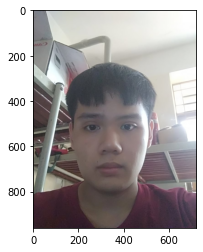

In [33]:
Prediction('/content/107249001_262789848350777_3109014002307573199_n.jpg',SVC_model)
Prediction('/content/107249001_262789848350777_3109014002307573199_n.jpg',KNN_model)

Male
Male


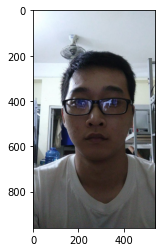

In [ ]:
Prediction('/content/107018152_641445023394853_3602848203512023224_n.jpg',SVC_model)
Prediction('/content/107018152_641445023394853_3602848203512023224_n.jpg',KNN_model)

Male
Male


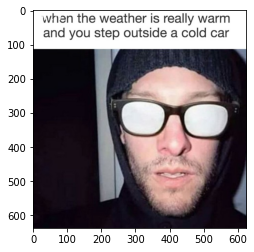

In [ ]:
Prediction('/content/24606-a475e5051cc121a5fca6d1fcb147a0c2-ohaytv.jpg',SVC_model)
Prediction('/content/24606-a475e5051cc121a5fca6d1fcb147a0c2-ohaytv.jpg',KNN_model)

Male
Male


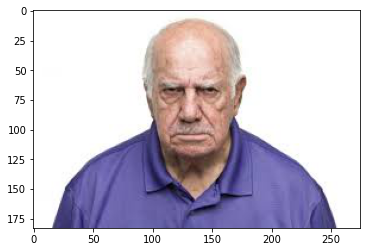

In [ ]:
Prediction('/content/images (1).jpg',SVC_model)
Prediction('/content/images (1).jpg',KNN_model)

Female
Female


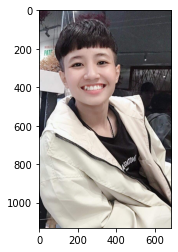

In [ ]:
Prediction('/content/received_470836120140904.jpeg',SVC_model)
Prediction('/content/received_470836120140904.jpeg',KNN_model)

Female
Female


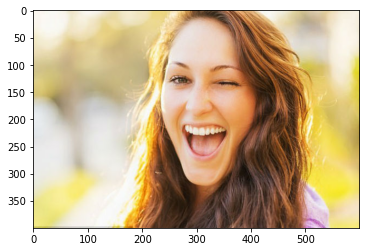

In [ ]:
Prediction('/content/1909465.jpg',SVC_model)
Prediction('/content/1909465.jpg',KNN_model)

Female
Female


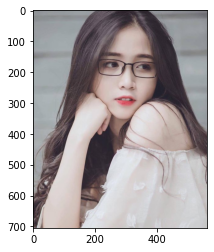

In [ ]:
Prediction('/content/bi-quyet-giup-ban-tro-thanh-co-gai-diu-dang-nu-tinh-c59b59.jpg',SVC_model)
Prediction('/content/bi-quyet-giup-ban-tro-thanh-co-gai-diu-dang-nu-tinh-c59b59.jpg',KNN_model)

Female
Female


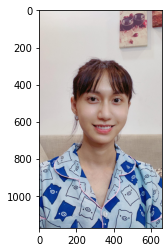

In [ ]:
Prediction('/content/90235273_10157509225939234_3700863994865647616_o.jpg',SVC_model)
Prediction('/content/90235273_10157509225939234_3700863994865647616_o.jpg',KNN_model)

Male
Male


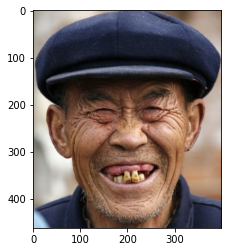

In [ ]:
Prediction('/content/82_0_2_20170111210612356.jpg',SVC_model)
Prediction('/content/82_0_2_20170111210612356.jpg',KNN_model)

Male
Female


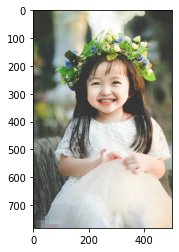

In [ ]:
Prediction('/content/quan-ao-tre-em-he-qua-cua-tre-em-noi-tien-qua-som-1.jpg',SVC_model)
Prediction('/content/quan-ao-tre-em-he-qua-cua-tre-em-noi-tien-qua-som-1.jpg',KNN_model)

Male
Male


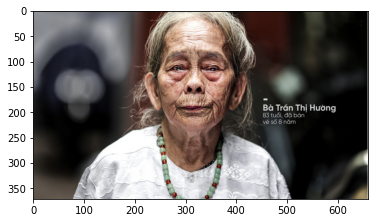

In [ ]:
Prediction('/content/1-2-15214374669621425193998 (1).jpg',SVC_model)
Prediction('/content/1-2-15214374669621425193998 (1).jpg',KNN_model)

Male
Male


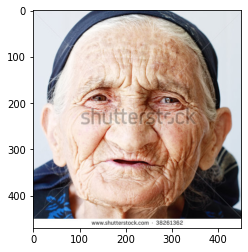

In [ ]:
Prediction('/content/100_1_0_20170110183726390.jpg',SVC_model)
Prediction('/content/100_1_0_20170110183726390.jpg',KNN_model)

Female
Female


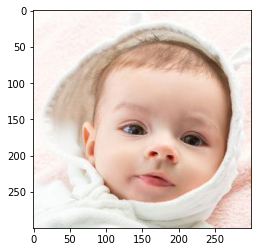

In [ ]:
Prediction('/content/1_0_0_20161219203009924.jpg',SVC_model)
Prediction('/content/1_0_0_20161219203009924.jpg',KNN_model)

Female
Female


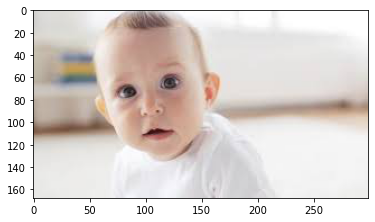

In [ ]:
Prediction('/content/1_0_0_20161219140642920.jpg',SVC_model)
Prediction('/content/1_0_0_20161219140642920.jpg',KNN_model)

Thêm dataset để train lại 

In [ ]:
add_images_folder=main_folder+'additional_face/'
add_df_attr=pd.read_excel(main_folder+'addtional_gender_dataset.xlsx',)
from sklearn.model_selection import train_test_split
x=add_df_attr['Id_image']
y=add_df_attr['Male']
add_x_train,add_x_test,add_y_train,add_y_test=train_test_split(x,y,test_size=0.2,random_state=42)
arr_add_faces_train=load_add_faces(add_x_train)
arr_add_faces_test=load_add_faces(add_x_test)
savez_compressed('add-faces-dataset.npz', arr_add_faces_train, add_y_train, arr_add_faces_test, add_y_test)

Trích xuất các faces_embedding từ data mới

In [ ]:
add_face_dataset=main_folder+'add-faces-dataset.npz'
data=np.load(add_face_dataset)
add_trainX,add_trainY,add_testX,add_testY=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
print('Loaded: ',add_trainX.shape, add_trainY.shape, add_testX.shape, add_testY.shape)
print('Loaded Model')
add_newTrainX = list()
for face_pixels in add_trainX:
	embedding = get_embedding(extract_model, face_pixels)
	add_newTrainX.append(embedding)
add_newTrainX = asarray(add_newTrainX)
print(add_newTrainX.shape)
# convert each face in the test set to an embedding
add_newTestX = list()
for face_pixels in add_testX:
	embedding = get_embedding(extract_model, face_pixels)
	add_newTestX.append(embedding)
add_newTestX = asarray(add_newTestX)
print(add_newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('add-faces-embeddings.npz', add_newTrainX, add_trainY, add_newTestX, add_testY)

Loaded:  (160, 160, 160, 3) (160,) (40, 160, 160, 3) (40,)
Loaded Model
(160, 128)
(40, 128)


In [ ]:
data = np.load(main_folder+'faces-embeddings.npz')
add_data=np.load(main_folder+'add-faces-embeddings.npz')
newTrainX, trainY, newTestX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
add_newTrainX, add_trainY, add_newTestX, add_testY = add_data['arr_0'], add_data['arr_1'], add_data['arr_2'], add_data['arr_3']
final_newTrainX=np.append(newTrainX,add_newTrainX,axis=0)
final_newTestX=np.append(newTestX,add_newTestX,axis=0)
final_trainY=np.append(trainY,add_trainY,axis=0)
final_testY=np.append(testY,add_testY,axis=0)

In [ ]:
male,female=0,0
for i in final_trainY:
   if i==1: male+=1
   else: female+=1
for i in final_testY:
   if i==1:male+=1
   else: female+=1
print('male:',male)
print('female:',female)

male: 919
female: 1281


In [ ]:
from sklearn.preprocessing import Normalizer
# normalize input vectors
in_encoder = Normalizer(norm='l2',)
final_newTrainX = in_encoder.transform(final_newTrainX)
final_newTestX = in_encoder.transform(final_newTestX)

In [ ]:
KNN_model=KNeighborsClassifier(n_neighbors=10,weights='distance')
KNN_model.fit(final_newTrainX,final_trainY)
KNN_predict_train=KNN_model.predict(final_newTrainX)
KNN_predict=KNN_model.predict(final_newTestX)
from sklearn.metrics import f1_score
print(f1_score(final_trainY,KNN_predict_train))
print(f1_score(final_testY,KNN_predict))

1.0
0.931129476584022


In [ ]:
SVC_model.fit(final_newTrainX,final_trainY)
SVC_predict_train=SVC_model.predict(final_newTrainX)
SVC_predict=SVC_model.predict(final_newTestX)
from sklearn.metrics import f1_score
print(f1_score(final_trainY,SVC_predict_train))
print(f1_score(final_testY,SVC_predict))

0.969738651994498
0.9351351351351351


Female
Female


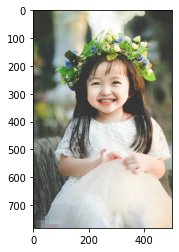

In [ ]:
Prediction('/content/quan-ao-tre-em-he-qua-cua-tre-em-noi-tien-qua-som-1.jpg',SVC_model)
Prediction('/content/quan-ao-tre-em-he-qua-cua-tre-em-noi-tien-qua-som-1.jpg',KNN_model)

Female
Female


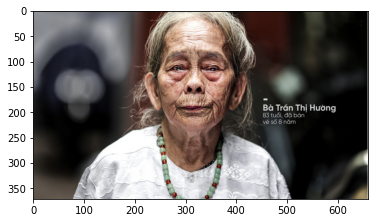

In [ ]:
Prediction('/content/1-2-15214374669621425193998 (1).jpg',SVC_model)
Prediction('/content/1-2-15214374669621425193998 (1).jpg',KNN_model)

Female
Female


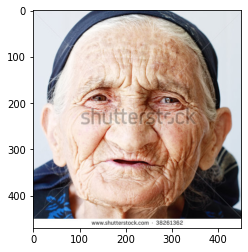

In [ ]:
Prediction('/content/100_1_0_20170110183726390.jpg',SVC_model)
Prediction('/content/100_1_0_20170110183726390.jpg',KNN_model)

Female
Female


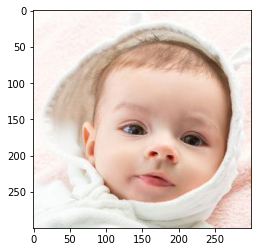

In [ ]:
Prediction('/content/1_0_0_20161219203009924.jpg',SVC_model)
Prediction('/content/1_0_0_20161219203009924.jpg',KNN_model)

Female
Male


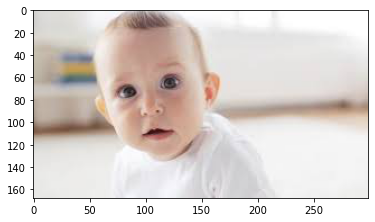

In [ ]:
Prediction('/content/1_0_0_20161219140642920.jpg',SVC_model)
Prediction('/content/1_0_0_20161219140642920.jpg',KNN_model)

Male
Female


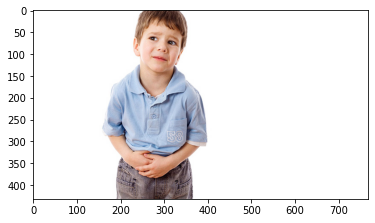

In [ ]:
Prediction('/content/cach-dieu-tri-viem-hang-vi-da-day-o-tre-em.jpg',SVC_model)
Prediction('/content/cach-dieu-tri-viem-hang-vi-da-day-o-tre-em.jpg',KNN_model)